# Data Generation

This notebook covers optional code to recreate the artificially created real estate assets. To spare API costs, the whole generation can be skipped and alternatively the pre-generated content can be utilized, in the provided pickle file _generated_raw_assets.pickle_

**Note**: this Jupyter notebook does not to be run directly, it can be executed from _real_estate_agent.ipynb_ directly. If unsure leave thise notebook

First let's verify basic OpenAI operability

In [1]:
import openai
import os
from openai import OpenAI

with open("./open-ai.apikey", "r") as keyfile:
    key = keyfile.readline().replace("\n","")
    assert len(key.split()) == 1, f"expecting only the personal OpenAI API key, got >> {key.split()} << instead"
    

os.environ["OPENAI_API_KEY"] = key
os.environ["OPENAI_API_BASE"] = "https://openai.vocareum.com/v1"

# Quick API check
client = OpenAI(api_key=key, base_url="https://openai.vocareum.com/v1")
client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {'role': 'user', 'content': 'What is a good question?'}
            ],
            temperature=0,
            max_tokens=100)

voc-567911689126677366020567377ac6ea50e5.51031601


ChatCompletion(id='chatcmpl-AnAbEli1EeRHsakCuYkt0jS9GDxmq', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1736282180, model='gpt-3.5-turbo-0125', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=100, prompt_tokens=36, total_tokens=136, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

# LLM Interaction

To facilitate the code handling, first a common interface to the LLM is created, so the focus can be on the specific real estate case and not unrelated API handling.

Question:
 What is a wonderful place to look for in a new home?

Response:
A wonderful place to look for in a new home can vary depending on your preferences and lifestyle. Some popular factors to consider include:

1. Safety: Look for a neighborhood with low crime rates and a sense of security.

2. Schools: If you have children or are planning to in the future, consider the quality of schools in the area.

3. Amenities: Check for nearby amenities such as parks, shopping centers, restaurants, and recreational facilities.

4. Commute: Consider the proximity to your workplace and the ease of access to public transportation.

5. Community: Look for a neighborhood with a sense of community, friendly neighbors, and local events.

6. Nature: If you enjoy outdoor activities, consider a location with access to parks, hiking trails, or water bodies.

Ultimately, the best place to look for in a new home is one that aligns with your personal preferences and lifestyle needs.



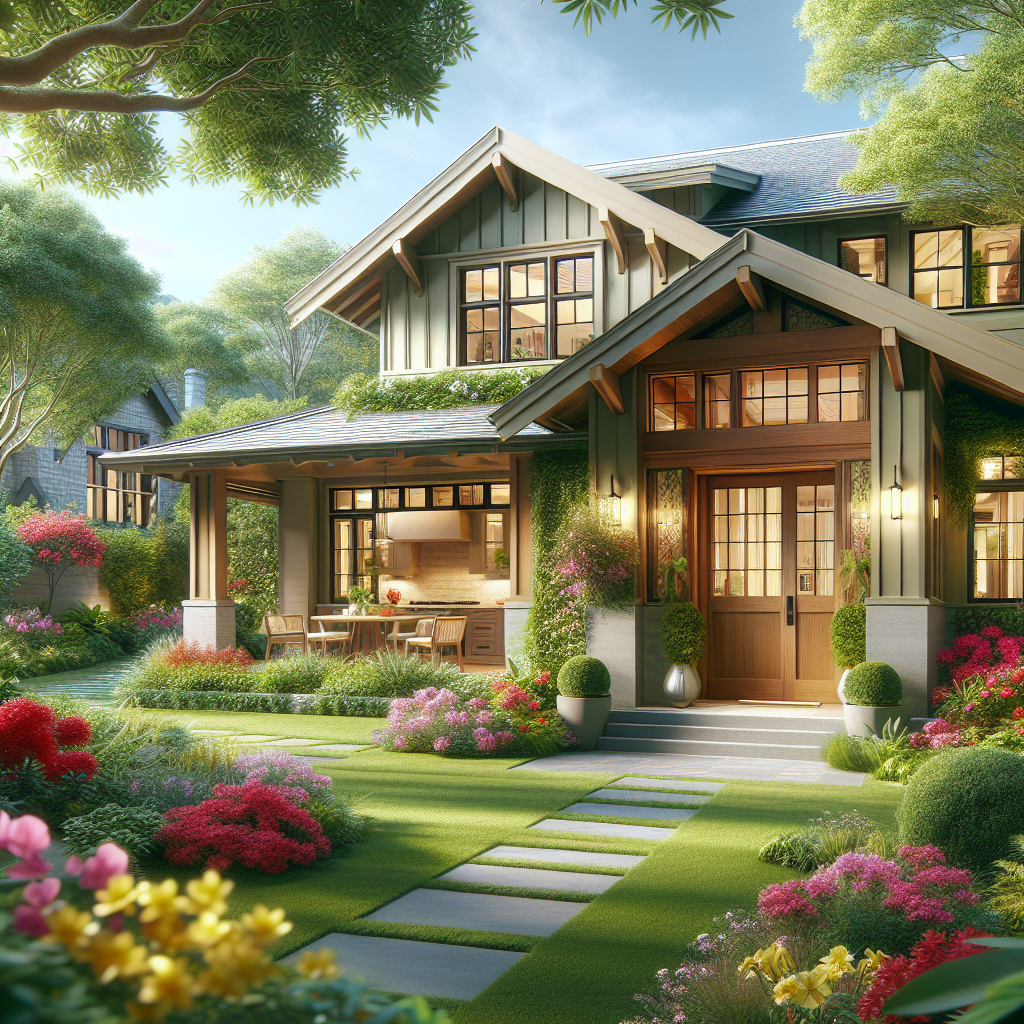

In [2]:
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display

class GenAI:
    def __init__(self, key):
        self._client = OpenAI(api_key=key, base_url="https://openai.vocareum.com/v1")

    def query_LLM(self,
            prompt,
            model="gpt-3.5-turbo",
            temperature=0.5,
            max_tokens=1000,
            response_format="json"):

        messages = [
            {"role": "system", "content": "You are a helpful data creator"},
            {"role": "user", "content": prompt},
        ]
        
        response = self._client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens)

        if "error" in response:
            raise openai.InvalidRequestError(response["error"], param=None)
        else:
            return response.choices[0].message.content

    def query_image_generator(self,
            prompt,
            model="dall-e-3",
            quality="standard",
            ):
        response = self._client.images.generate(
            model="dall-e-3",
            prompt=prompt,
            quality=quality
        )
        
        image_url = response.data[0].url
        image_response = requests.get(image_url) 
        return Image.open(BytesIO(image_response.content)) 

client = GenAI(key)

# quick test
query = "What is a wonderful place to look for in a new home?"
response = client.query_LLM(query)
image = client.query_image_generator(query)
print(f"Question:\n==========\n{query}\n\nResponse:\n==========\n{response}\n==========\n")
display(image)

## Creating content

The LLM should create artifical real estate data. To make these offers a bit more versatile, the LLM is supported with a set of attributes that it should describe for each item.

In [3]:
city = "Nuremberg"
style = "arbitrary, individual, low-correlating"
categories = [
    ("Neighborhood", "The name of the area"),
    ("Price", "The value for the housing object"),
    ("Bedrooms", "The amount of bedrooms the housing object offers"),
    ("Bathrooms", "The amount of bathrooms the housing object offers"),
    ("Living space", "The area that the housing object offers in square meters"),
    ("Neighborhood description", "A description what the vicinity looks like"),
    ("Parking space", "A description what the parking options are for the home owner"),
    ("Heating", "The type of the main heating source"),
    ("Internet", "The bandwith of available internet connection")
]
top_key = "offers"
num_samples = 10
response_format = "'json'"

With this base description, the LLM should create the offers and return it as a list in a machine processible format (e.g. json).

**Note**: it might be that at this point the code needs to be manually tweaked, as it cannot be 100 % guaranteed that LLM's response is in the expected state. A set of asserts should verify the response can be used to continue the processing

In [4]:
import json

prompt = f"Create a {response_format} with {num_samples} {style}, real estate offers in {city}. Use '{top_key}' as json key for the list of offers and use the following categories:\n"
for category in categories:
    prompt += f"- {category[0]}: {category[1]}\n"

    
response_special_format = client.query_LLM(prompt)
response = response_special_format.replace("```json", "").replace("```","")

offer_descriptions = json.loads(response)
assert isinstance(offer_descriptions, dict), f"Can't work with non-dict type:\n\n{offer_descriptions}"
assert len(offer_descriptions.keys()) == 1 and offer_descriptions.get(top_key, False), f"Expecting a json with a single main key '{top_key}', received the following instead:\n\n{offer_descriptions}"
assert len(offer_descriptions[top_key]) == num_samples, f"Received less than expected samples: {len(offer_description[top_key])} instead {num_samples}"
for offer in offer_descriptions[top_key]:
    for category in categories:
        assert category[0] in offer.keys(), f"Could not find all expected categories ({category[0]}) for this object:\n\n{offer}"

offer_descriptions

{'offers': [{'Neighborhood': 'Altstadt',
   'Price': 320000,
   'Bedrooms': 2,
   'Bathrooms': 1,
   'Living space': 70,
   'Neighborhood description': 'Historic area with charming cobblestone streets',
   'Parking space': 'Street parking available',
   'Heating': 'Gas',
   'Internet': '100 Mbps'},
  {'Neighborhood': 'Gostenhof',
   'Price': 250000,
   'Bedrooms': 1,
   'Bathrooms': 1,
   'Living space': 50,
   'Neighborhood description': 'Bohemian neighborhood with artsy vibe',
   'Parking space': 'Public parking nearby',
   'Heating': 'Electric',
   'Internet': '50 Mbps'},
  {'Neighborhood': 'St. Johannis',
   'Price': 420000,
   'Bedrooms': 3,
   'Bathrooms': 2,
   'Living space': 90,
   'Neighborhood description': 'Quiet residential area with parks',
   'Parking space': 'Private garage',
   'Heating': 'Oil',
   'Internet': '200 Mbps'},
  {'Neighborhood': 'Maxfeld',
   'Price': 380000,
   'Bedrooms': 2,
   'Bathrooms': 1,
   'Living space': 80,
   'Neighborhood description': 'Up-and

to spice up the illustration, not only text but also fitting images of the individual offers should be created. Therefore the numeric attributes are transformed into a more quantized state, in order to make it easier for DALL-E to interprete the query.

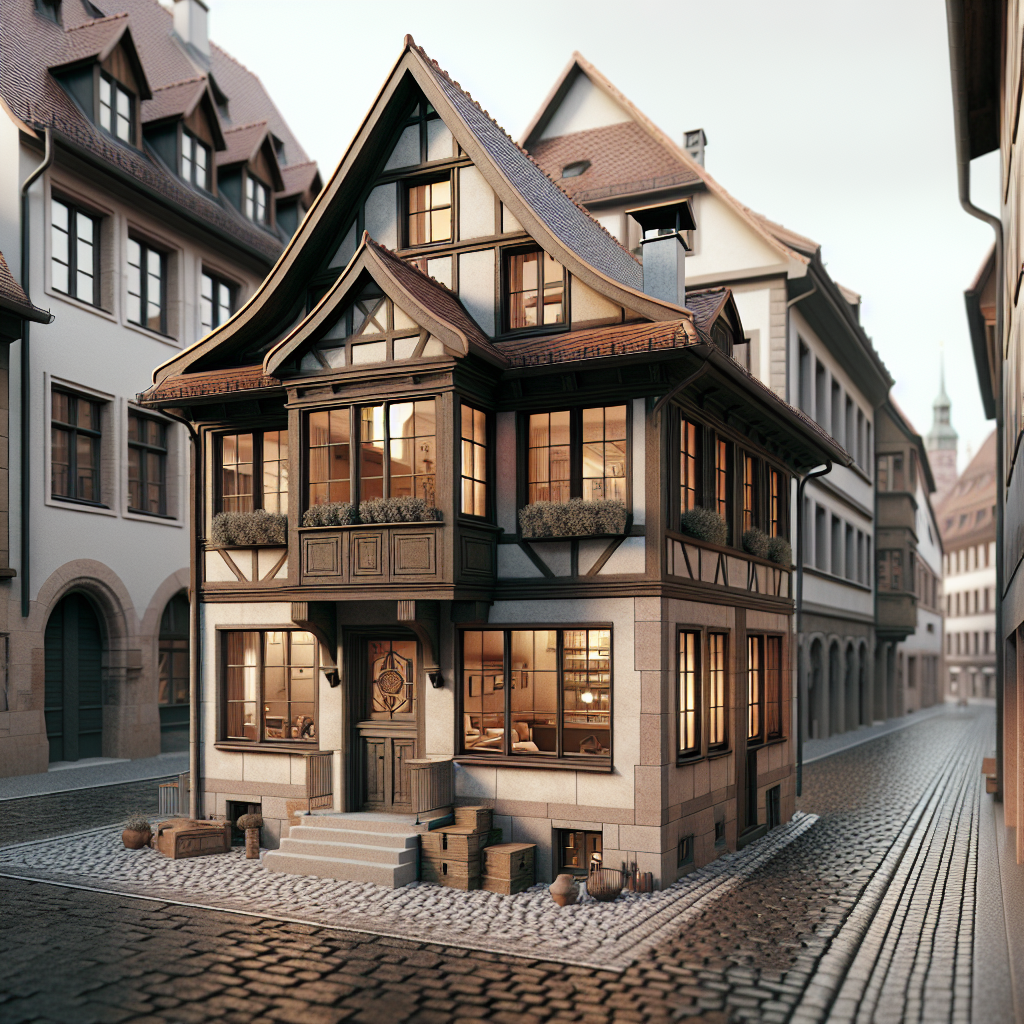

In [6]:
offers_media = []
for idx, offer in enumerate(offer_descriptions[top_key]):
    print(f"Creating image for {idx + 1}. item")
    price_attribute = "pricy" if offer["Price"] > 1_000_000 else "affordable"
    space_attribute = "confined" if offer["Living space"] < 200 else "roomy"
    query = f'A {price_attribute} house with a realisitc style in {city}, {offer["Neighborhood"]} living space is {space_attribute}, vicinity is like {offer["Neighborhood description"]}'    
    image = client.query_image_generator(query)
    offers_media.append((idx, query, image))
    
display(offers_media[0][2])

as a last step all the created data is exported and permanently stored for further usage in the other Jupyter notebook _real_estate_agent.ipynb_

In [7]:
import pickle
import os
from Common import ASSETS_FILE_PATH, ExportAsset
    
export_data = []
for item in offers_media:
    idx = item[0]
    subtitle = item[1]
    image = item[2]
    description = offer_descriptions[top_key][idx]
    export_data.append(ExportAsset(
        description,
        image,
        subtitle
        ))
    
with open(FRESH_ASSETS_FILE_PATH, 'wb') as file_handle:
    pickle.dump(export_data, file_handle, protocol=pickle.HIGHEST_PROTOCOL)

[INFO] Overwriting original file /home/frank-ai/workspace/GenAI/llm-real-estate-agent/generated_raw_assets.pickle
